In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
from numba import njit
import matplotlib.pyplot as plt

from vivarium.test_util import build_simulation_configuration, setup_simulation, pump_simulation

# Setup a base population component to set up the state table.

We have to do a bit of weird stuff to include multiple agent types.  

In [12]:
class BasePopulation:
    configuration_defaults = {
        'population': {
            'number_of_boids': 100,
            'number_of_prey': 0,
            'number_of_predators': 0,
        }
    }
    
    def setup(self, builder):
        columns = ['type', 'mass', 'alive', 'cause_of_death']
        self.population_view = builder.population.get_view(columns=columns)
        builder.population.initializes_simulants(self.on_create_simulants, creates_columns=columns)
        
        self.config = builder.configuration.population        
    
    def on_create_simulants(self, pop_data):
        num_boids = pop_data.user_data.get('number_of_boids', self.config.number_of_boids)
        num_prey = pop_data.user_data.get('number_of_prey', self.config.number_of_prey)
        num_predators = pop_data.user_data.get('number_of_predators', self.config.number_of_predators)
        sim_types = pd.Series(
            ['boid']*num_boids + ['prey']*num_prey + ['predator']*num_predators, index=pop_data.index)
        sim_masses = pd.Series(0, index=pop_data.index)
        self.population_view.update(pd.DataFrame({'type': sim_types,
                                                  'mass': sim_masses, 
                                                  'alive': [1]*len(pop_data.index),
                                                  'cause_of_death': ['None']*len(pop_data.index)}))



# Some Boids specific population configuration

We'll have them lose mass over time due to energy expenditure

In [29]:
class BoidsPopulation:
    configuration_defaults = {
        'boids': {
            'mass_range': [2, 10],
            'growth_rate': -.01, # Boids use energy to fly
            'velocity_max': 1,
        }
    }
    
    def setup(self, builder):
        self.config = builder.configuration.boids        
        self.randomness = builder.randomness.get_stream('boids_initialization')
        
        self.population_view = builder.population.get_view(columns=['type', 'mass', 'alive'], 
                                                           query='type == "boid" and alive == 1')
        builder.population.initializes_simulants(self.on_create_boids, 
                                                 requires_columns=['type', 'mass', 'alive'])
        
        builder.event.register_listener('time_step', self.on_time_step)
        
    def on_create_boids(self, pop_data):
        mass_min, mass_max = self.config.mass_range
        masses = self.randomness.get_draw(pop_data.index) * (mass_max - mass_min) + mass_min
        masses.name = 'mass'
        pop = self.population_view.get(pop_data.index)        
        pop['mass'] = masses
        self.population_view.update(pop)
        
    def on_time_step(self, event):
        pop = self.population_view.get(event.index)        
        pop.loc[:, 'mass'] *= 1 + self.config.growth_rate        
        self.population_view.update(pop)      
        



# Death if you lose enough mass.  It ain't easy bein' a boid.

In [30]:
class BoidsStarvation:
    def setup(self, builder):
        self.min_mass = builder.configuration.boids.mass_range[0]
        self.population_view = builder.population.get_view(columns=['type', 'mass', 'alive', 'cause_of_death'], 
                                                           query='type == "boid" and alive == 1')
        
        builder.event.register_listener('time_step', self.on_time_step)        
    
    def on_time_step(self, event):
        pop = self.population_view.get(event.index)
        died = pop['mass'] < self.min_mass
        pop.loc[died, 'alive'] = 0
        pop.loc[died, 'cause_of_death'] = 'starvation'
        self.population_view.update(pop)

### Let's make sure everything so far works

In [31]:
components = [BasePopulation(), BoidsPopulation(), BoidsStarvation()]
sim = setup_simulation(components, population_size=100) # The population size thing here sucks

In [32]:
pop = sim.population.population
pop.groupby('type')['mass'].mean()

type
boid    5.48
Name: mass, dtype: float64

In [33]:
pop[pop.alive == 1].groupby('type')['alive'].count()

type
boid    100
Name: alive, dtype: int64

In [34]:
pump_simulation(sim, iterations=100)

VBox(children=(HTML(value=''), IntProgress(value=0)))

100

In [35]:
pop = sim.population.population
pop.groupby('type')['mass'].mean()

type
boid    2.349754
Name: mass, dtype: float64

In [36]:
pop[pop.alive == 1].groupby('type')['alive'].count()

type
boid    49
Name: alive, dtype: int64

### Only boids have mass, lose mass, and die.  As expected

# Let's give them a place to fly around.

The territory also defines all the kinematic parameters we'll need later.  This is again due to the weirdness of shoving multiple agent types into the simulation.

In [41]:
# The field
class BoidsTerritory:
    configuration_defaults = {
        'territory': {
            'width': 50,
            'height': 50,
        }
    }
    
    def setup(self, builder):
        columns = ['p_x', 'p_y', 'v_x', 'v_y', 'a_x', 'a_y']
        self.population_view = builder.population.get_view(columns=columns)        
        builder.population.initializes_simulants(self.on_create_simulants,
                                                 creates_columns=columns)
    
        self.config = builder.configuration.territory
        self.randomness = builder.randomness.get_stream('initial_position')
    
    def on_create_simulants(self, pop_data):
        num_sims = len(pop_data.index)
        x_pos = (self.config.width + 1) * self.randomness.get_draw(pop_data.index, 'x_pos')
        y_pos = (self.config.height + 1) * self.randomness.get_draw(pop_data.index, 'y_pos')
        self.population_view.update(pd.DataFrame({'p_x': x_pos,
                                                  'p_y': y_pos,
                                                  'v_x': np.random.random(num_sims) + 1, 
                                                  'v_y': np.random.random(num_sims),
                                                  'a_x': [0.0]*num_sims, 
                                                  'a_y': [0.0]*num_sims}, 
                                                 index=pop_data.index))
        

In [42]:
components = [BasePopulation(), BoidsPopulation(), BoidsTerritory()]
sim = setup_simulation(components, population_size=100)

In [43]:
sim.population.population.head()

,v_x,v_y,a_y,a_x,p_y,p_x,mass,cause_of_death,type,alive
0,1.687947,0.017353,0.0,0.0,19.007387,40.907080,6.0,None,boid,1
1,1.328752,0.094329,0.0,0.0,6.940377,35.284138,4.0,None,boid,1
2,1.267433,0.372385,0.0,0.0,29.523646,10.365793,7.0,None,boid,1
3,1.267968,0.417775,0.0,0.0,19.953259,34.348005,3.0,None,boid,1
4,1.539196,0.349828,0.0,0.0,14.971175,26.508695,5.0,None,boid,1


# Time to fly!

"Simple"

In [48]:
class BoidsSimpleFlight:
    configuration_defaults = {
        'flight': {
            'basic_force': 1,  # How forceful is the tendency to keep flying in the direction we're going?
            'max_acceleration': 1,
            'max_jerk': 3,  # constrain the maximum change in acceleration.
        }
    }
    def setup(self, builder):
        self.basic_force = builder.configuration.flight.basic_force
        self.max_jerk = builder.configuration.flight.max_jerk        
        self.max_v = builder.configuration.boids.velocity_max
        self.territory_config = builder.configuration.territory
        
        columns = ['type', 'mass', 'p_x', 'p_y', 'v_x', 'v_y', 'a_x', 'a_y']
        self.population_view = builder.population.get_view(columns, query='type == "boid" and alive == 1')
        
        self.force = builder.value.register_value_producer('boids.force', 
                                                           source=self.basic_forcing_function)
        
        builder.event.register_listener('time_step', self.on_time_step)
        
        
    def on_time_step(self, event):
        pop = self.population_view.get(event.index)
        step_size = event.step_size/pd.Timedelta(days=1)  #vivarium convention of time step in days
        
        # Woo kinematics.  This assumes constant acceleration. 
        # This will require some tuning and is why the `max_jerk` parameter exists.  
        # It needs to be balanced against the maximum velocities in order to come out okay.
        pop['p_x'] += (pop['v_x'] * step_size + 1/2 * pop['a_x'] * step_size**2) 
        pop['p_y'] += (pop['v_y'] * step_size + 1/2 * pop['a_y'] * step_size**2 ) 
        pop['v_x'] += pop['a_x'] * step_size
        pop['v_y'] += pop['a_y'] * step_size
        
        
        new_a = self.calculate_new_acceleration(pop[['mass', 'a_x', 'a_y']])
        pop['a_x'] = new_a['a_x']
        pop['a_y'] = new_a['a_y']
        
        self.population_view.update(pop)
        
    def basic_forcing_function(self, index):
        pop = self.population_view.get(index)
        v = np.sqrt(pop['v_x']**2 + pop['v_y']**2)
        
        # A signed proportion of the difference between our actual and desired velocity
        dv = 1 - v/self.max_v
        scale = self.basic_force * dv
        return pd.DataFrame({'force_x': scale*pop['v_x']/v, 
                             'force_y': scale*pop['v_y']/v})
    
    def calculate_new_acceleration(self, pop):
        force = self.force(pop.index)
        new_a_x = force['force_x']/pop['mass']
        new_a_y = force['force_y']/pop['mass']
        da = np.sqrt((new_a_x - pop['a_x'])**2 + (new_a_y - pop['a_y'])**2)
        new_a_x[da > self.max_jerk] *= self.max_jerk/da
        new_a_y[da > self.max_jerk] *= self.max_jerk/da
        
        return pd.DataFrame({'a_x': new_a_x, 'a_y': new_a_y}, index=pop.index)

In [53]:
from matplotlib import animation
import seaborn as sns
# making things look nice is always fiddley

def my_plot(df):
    x = df.p_x % 400
    y = df.p_y % 400
    
    # is there an easy way to plot the velocities?
    #xx = []
    #yy = []
    #for i in df.index:
    #    xx += [x[i], x[i]+df.v_x[i], np.nan]
    #    yy += [y[i], y[i]+df.v_y[i], np.nan]

    #plt.plot(xx, yy, sns.xkcd_rgb['light blue'])
    plt.plot(x, y, 'k.')
    plt.axis(xmin=0, ymin=0, xmax=400, ymax=400)
    plt.xticks([])
    plt.yticks([])


class MovieWriter:
    def __init__(self, fname):
        self.moviewriter = animation.ImageMagickWriter(fps=10)
        self.fname = fname
            
    def __enter__(self):
        fig = plt.figure()
        self.moviewriter.setup(fig, self.fname, dpi=100)
        return self
    
    def setup(self, builder):
        self.population_view = builder.population.get_view(['p_x', 'p_y', 'v_x', 'v_y'])
        builder.event.register_listener('collect_metrics', self.on_collect_metrics)        
    
    def on_collect_metrics(self, event):
        pop = self.population_view.get(event.index)
        
        plt.clf()
        my_plot(pop)

        self.moviewriter.grab_frame()

    def __exit__(self, exception_type, exception_value, traceback):
        self.moviewriter.finish()


VBox(children=(HTML(value=''), IntProgress(value=0, max=50)))

CPU times: user 4.57 s, sys: 69.6 ms, total: 4.64 s
Wall time: 4.96 s


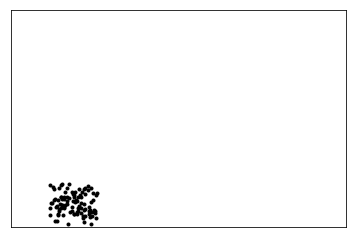

In [54]:
%%time

with MovieWriter('t.gif') as mw:
    sim = setup_simulation([BasePopulation(), BoidsPopulation(), BoidsTerritory(), BoidsSimpleFlight(), mw],
                               population_size=100)
    pump_simulation(sim, iterations=50)

# Cool let's add some boids rules

In [57]:
class CentralTendency:
    configuration_defaults = {
        'central_tendency': {
            'force': .1,
        }
    }
    
    def setup(self, builder):
        self.force = builder.configuration.central_tendency.force
        self.population_view = builder.population.get_view(['p_x', 'p_y'], 
                                                       query='type == "boid" and alive == 1')
        builder.value.register_value_modifier(value_name='boids.force', modifier=self.force_towards_center)
    
    def force_towards_center(self, index, force):
        pop = self.population_view.get(index)
        cx, cy = pop['p_x'].mean(), pop['p_y'].mean()
        d = np.sqrt((pop['p_x'] - cx)**2 + (pop['p_y'] - cy)**2)
        force['force_x'] += self.force * (cx - pop['p_x'])/d
        force['force_y'] += self.force * (cy - pop['p_y'])/d
        return force

VBox(children=(HTML(value=''), IntProgress(value=0, max=150)))

CPU times: user 15 s, sys: 249 ms, total: 15.3 s
Wall time: 16 s


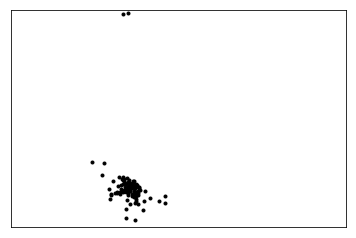

In [58]:
%%time

with MovieWriter('t.gif') as mw:
    sim = setup_simulation([BasePopulation(), BoidsPopulation(), BoidsTerritory(), BoidsSimpleFlight(), 
                            CentralTendency(), mw],
                               population_size=100)
    pump_simulation(sim, iterations=150)

In [59]:
class AvoidPersonalSpace:
    configuration_defaults = {
        'personal_space': {
            'force': .03,
            'radius': 3,
        }
    }
    def setup(self, builder):
        self.force = builder.configuration.personal_space.force
        self.radius = builder.configuration.personal_space.radius
        
        self.population_view = builder.population.get_view(['p_x', 'p_y'], 
                                                           query='type == "boid" and alive == 1')
        builder.value.register_value_modifier(value_name='boids.force', modifier=self.keep_away)
        
    def keep_away(self, index, force):
        pop = self.population_view.get(index)
        f_x, f_y = get_forces(pop['p_x'].values, 
                              pop['p_y'].values, 
                              self.force,
                              force['force_x'].values, 
                              force['force_y'].values)
        force.loc[:, 'force_x'] += f_x
        force.loc[:, 'force_y'] += f_y
        return force

@njit            
def get_forces(x_pos, y_pos, force_scale, x_force, y_force):
    for i, (x1, y1) in enumerate(zip(x_pos, y_pos)):
        for j, (x2, y2) in enumerate(zip(x_pos, y_pos)):
            if i != j:
                dx = x2 - x1
                dy = y2 - y1
                r3 = (dx**2 + dy**2)**3/2
                x_force[i] += dx/r3*force_scale
                y_force[i] += dy/r3*force_scale
    return x_force, y_force

VBox(children=(HTML(value=''), IntProgress(value=0, max=150)))

CPU times: user 15.2 s, sys: 258 ms, total: 15.4 s
Wall time: 16.1 s


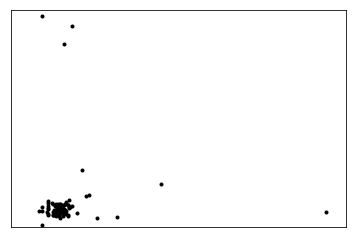

In [60]:
%%time

with MovieWriter('t.gif') as mw:
    sim = setup_simulation([BasePopulation(), 
                            BoidsPopulation(), 
                            BoidsTerritory(), 
                            BoidsSimpleFlight(), 
                            CentralTendency(), 
                            AvoidPersonalSpace(),
                            mw],
                           population_size=100)
    pump_simulation(sim, iterations=150)